In [1]:
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
data = pd.read_csv('./sw_classifications_20160527.csv')

In [3]:
data.head()

,swi_id,swj_id,swi_geom,swj_geom,connected,username,timestamp
0,309963,317735,010200000002000000FB3CEA9DC7935EC08902972360CC...,010200000002000000699C891DF0935EC060CB94877CCC...,f,Sumit,2016-05-24 02:29:15.820404+00
1,313312,313373,010200000002000000A2BCE99980925EC0D7DE25935DCC...,010200000002000000182B66EE92925EC00F6FA3F743CC...,t,Annie T,2016-05-26 03:27:50.283528+00
2,304826,305160,010200000002000000E39CA78061935EC0A92043F180D6...,010200000002000000CB14431650935EC00E56906ABAD6...,f,Annie T,2016-05-26 03:44:58.635554+00
3,306273,306938,010200000002000000C9C226BCB5955EC0568370BE61D8...,01020000000200000043E1C5F69E955EC058E9BFB429D8...,f,Anonymous,2016-05-26 04:24:03.041748+00
4,306373,306697,0102000000020000006F1D84D861925EC065187A35F8D6...,01020000000200000027997E7153925EC0A637A03531D7...,f,sophia,2016-05-26 05:12:59.299378+00


We want to only consider sidewalk pairs that have at least 3 labels.

In [5]:
gb = data.groupby(['swi_id', 'swj_id'])
groups = gb.groups
more_3 = {key: value for key, value in groups.iteritems() if len(value) >= 3}
more_2 = {key: value for key, value in groups.iteritems() if len(value) >= 2}
print 'Number of unique sidewalk pair labels: {}'.format(len(groups))
print 'Number of labels with 3 or more responses: {}'.format(len(more_3))
print 'Number of labels with 2 or more responses: {}'.format(len(more_2))

Number of unique sidewalk pair labels: 11132
Number of labels with 3 or more responses: 1947
Number of labels with 2 or more responses: 1971


The groups are a dictionary of group element + index. To get to the actual labels, we can just grab the row at that index from our data frame.

In [6]:
more_2.items()[:3]

[((325902, 326474), [6366, 13072, 15004]),
 ((295084, 298785), [9498, 12565, 12655]),
 ((326184, 326185), [826, 11387, 11430])]

In [7]:
def label_fraction(sw_labelset):
    '''
    :param sw_labelset: List of 't' (True) or 'f' (False) labels for a single sidewalk pair.
    :type sw_labelset: list
    
    '''
    tf = data.iloc[sw_labelset, :]['connected']
    fraction_t = sum([1 for label in tf if label == 't']) / float(len(sw_labelset))
    
    return fraction_t

def decide_label(fraction):
    '''Decide how to label a given sidewalk pair given multiple responses.'''
    # If majority is 't', choose 't'
    if fraction > 0.5:
        return 't'
    # If majority is 'f', choose 'f'
    elif fraction < 0.5:
        return 'f'
    # If even split, ignore entirely for now
    else:
        return None

In [9]:
fractions2 = []
labels2 = []
for key, value in more_2.iteritems():
    fraction = label_fraction(value)
    label = decide_label(fraction)
    if label is not None:
        newrow = data.ix[value[0],['swi_id', 'swj_id', 'connected']]
        newrow['connected'] = label
        labels2.append(newrow)
        fractions2.append(fraction)

labels2 = pd.DataFrame(labels2)
labels2.head()

,swi_id,swj_id,connected
6366,325902,326474,f
9498,295084,298785,t
826,326184,326185,f
2638,297773,303110,f
2015,322238,330093,f


In [11]:
fractions3 = []
labels3 = []
for key, value in more_3.iteritems():
    fraction = label_fraction(value)
    label = decide_label(fraction)
    if label is not None:
        newrow = data.ix[value[0],['swi_id', 'swj_id', 'connected']]
        newrow['connected'] = label
        labels3.append(newrow)
        fractions3.append(fraction)

labels3 = pd.DataFrame(labels3)
labels3.head()

,swi_id,swj_id,connected
6366,325902,326474,f
9498,295084,298785,t
826,326184,326185,f
2638,297773,303110,f
2015,322238,330093,f


In [12]:
labels2['connected'].describe()

count     1969
unique       2
top          f
freq      1533
Name: connected, dtype: object

In [13]:
labels3['connected'].describe()

count     1946
unique       2
top          f
freq      1514
Name: connected, dtype: object

(array([ 1463.,     0.,     0.,    51.,     0.,     0.,    46.,     0.,
            0.,   386.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

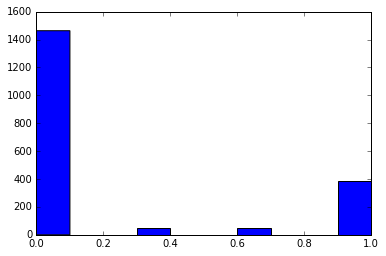

In [14]:
plt.hist(fractions3)

In [15]:
uncontested = [f for f in fractions3 if f != 0 and f != 1]
len(uncontested) / float(len(fractions3))

0.04984583761562179

'labels2' contains all majority-rule labels that have 2 or more responses. 'labels3' contains all majority-rule labels that have 3 or more responses.

### Gini coefficient

We want to use the Gini coefficient to measure the distribution of user responses - i.e., do we have a few power users providing all the data, or evenly-distributed, or something in between? The Gini coefficient will give a near-0 value for equally-distributed work and a near-1 value for putting allt he work on just 1 user out of many.

The Gini coefficient was historically used on an income distribution over a population (it's an economics thing). It therefore expects 1-dimensional data. In our case, that 1-D data will be total number of submissions per user.

In [18]:
user_counts = data.groupby(['username']).count()['connected']
user_counts.head()

username
Annie T        258
Anonymous      266
Blue            11
Ladan          604
Lissi Sevao     21
Name: connected, dtype: int64

In [46]:
def gini_estimate(value_list):
    '''Calculates the Gini coefficient for a 1D numerical dataset. 
    Rather than using continuous Lorenz curve, uses linear interpolation with
    sorted discrete values.'''
    
    values = sorted(value_list)
    n = len(values)
    cum_height = 0
    cum_area = 0
    
    for value in values:
        cum_area += cum_height + (value - cum_height) / 2
        cum_height += value
        
    line_equality_area = cum_height * n / 2.
    
    print cum_area
    print line_equality_area
    
    return (line_equality_area - cum_area) / line_equality_area

In [47]:
gini_estimate(user_counts)

40031
218486.0


0.81678002251860526

In [49]:
user_counts

username
Annie T             258
Anonymous           266
Blue                 11
Ladan               604
Lissi Sevao          21
Maria R.             56
Sophia             3347
Sophs                 1
Stacey             1019
Stakeesha            18
Sumit               774
Tracy               129
VS                  301
Vero                300
ahmedq              162
arjunkhakhar        251
baryshev            222
caspian             584
chenwei1326          83
ladanmoz            213
lmbrettner          197
nbolten             204
randolph380          32
sifang              214
sophia              507
staceysunde        4606
sumitmukherjee2     370
sundipta            160
yaoyuyang           158
Name: connected, dtype: int64

In [50]:
data.shape

(15068, 7)

In [51]:
user_counts2 = data[data['username'] != 'Anonymous'].groupby(['username']).count()['connected']
gini_estimate(user_counts2)

37373
207228.0


0.8196527496284286

In [52]:
labels2

,swi_id,swj_id,connected
6366,325902,326474,f
9498,295084,298785,t
826,326184,326185,f
2638,297773,303110,f
2015,322238,330093,f
10274,319771,320091,t
19,312082,312687,f
7029,293176,293179,f
12113,292576,295367,f
1454,295705,295706,f


### Time-based analysis of user responses

Users may provide more or less accurate responses based on temporal behaviors. For example, a user that is rapidly answering questions may make more mistakes than one who is answering slowly, as it may indicate how careful the user is being. Or for another example, a user that has labeled 'No' several times in a row may accidentally click 'No' in a case that is clearly 'Yes', just because they're "in the zone".

To answer any of these questions, we should first extract the responses that we consider to be false positives and false negatives. We can only extract this information from the triplicate response dataset, so we may simply be limited by having too small of a dataset.

In [107]:
# We want to extract the rows in the data that say 'false' when the consensus was ruled 'true'
data_f = data[data['connected'] == 'f']
labels3_t = labels3[labels3['connected'] == 't']

# False negatives
data_fn = data_f[data_f['swi_id'].isin(labels3_t['swi_id']) & data_f['swj_id'].isin(labels3_t['swj_id'])]
data_fn.shape

(46, 7)

There are only 46 false positives, so we may be limited in how much meaning we can extract.

Because the frequency calculation will require session detection of some kind (if two users have the same speed of labeling but one took a much longer break between sessions, they'll have very different means), we're going to skip it for now.

What we can do more easily, however, is look at how many previous answers in a row were 'false' for the false negatives, per-user.

In [141]:
data['f_repeat'] = 0

for user in pd.Categorical(data['username']).categories:
    user_responses = data[data['username'] == user].sort_values(by='timestamp')
    user_reindexed = user_responses.reset_index()
    for i in range(user_reindexed.shape[0]):
        cur_index = i
        count = 0
        while cur_index:
            cur_index -= 1
            if user_reindexed.ix[cur_index, 'connected'] == 't':
                break
            else:
                count += 1
        orig_index = user_reindexed.ix[i, 'index']
        data.ix[orig_index, 'f_repeat'] = count

In [151]:
data['false_negative'] = False
data.ix[data_fn.index, 'false_negative'] = True
data[data['false_negative'] == True].shape

(46, 10)

(array([  2.18013580e-01,   1.70283584e-01,   1.31740114e-01,
          1.04247104e-01,   7.86845959e-02,   6.17094927e-02,
          4.75968579e-02,   3.78777793e-02,   2.99560644e-02,
          2.32991612e-02,   1.82399148e-02,   1.49114632e-02,
          1.17827187e-02,   9.78564772e-03,   8.25455998e-03,
          6.65690321e-03,   5.32552257e-03,   4.32698709e-03,
          3.59472773e-03,   3.19531354e-03,   2.39648516e-03,
          1.99707096e-03,   1.59765677e-03,   1.33138064e-03,
          8.65397417e-04,   7.32259353e-04,   5.99121289e-04,
          3.32845160e-04,   1.99707096e-04,   1.33138064e-04,
          1.33138064e-04,   1.99707096e-04]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]),
 <a list of 32 Patch objects>)

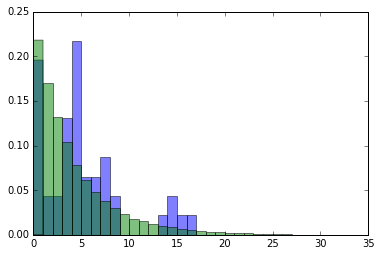

In [168]:
fns = data[data['false_negative'] == True]['f_repeat']
not_fns = data[data['false_negative'] != True]['f_repeat']

plt.hist(fns, normed=True, bins=range(fns.min(), fns.max() + 1, 1), alpha=0.5)
plt.hist(not_fns, normed=True, bins=range(not_fns.min(), not_fns.max() + 1, 1), alpha=0.5)